In [ ]:
# Load the data into a DataFrame 
df = pd.read_csv('cleaned_data.csv')
df

In [ ]:
from sklearn.model_selection import train_test_split, sklearn.metrics import classification_report
import joblib
from sklearn.metrics import classification_report

# Features Engeenering:
df['Demand_M_L_XL'] = df['Total Sizes_M, L, XL'] - (df['Available Sizes_M'] + df['Available Sizes_L'] + df['Available Sizes_XL'])
df['Demand_S_L_XL'] = df['Total Sizes_S, L, XL'] - (df['Available Sizes_S'] + df['Available Sizes_L'] + df['Available Sizes_XL'])
df['Demand_S_M_L'] = df['Total Sizes_S, M, L'] - (df['Available Sizes_S'] + df['Available Sizes_M'] + df['Available Sizes_L'])

# Example: Creating combined features for category and season
for category in ['Accessories', 'Activewear', 'Bottoms', 'Dresses', 'Footwear', 'Jewelry', 'Lingerie', 'Outerwear', 'Swimwear', 'Tops']:
    for season in ['Fall', 'Fall/Winter', 'Spring', 'Spring/Summer', 'Summer', 'Winter']:
        df[f'Category_{category}_Season_{season}'] = df[f'Category_{category}'] & df[f'Season_{season}']


# Target variable
target_column = 'Total Sizes_M, L, XL'  

# Features: Excluding direct size-related columns, but including category-season combinations
feature_columns = df.columns.drop(['Total Sizes_M, L, XL', 'Total Sizes_S, L, XL', 
                        'Total Sizes_S, M, L', 'Available Sizes_L', 
                        'Available Sizes_M', 'Available Sizes_S', 
                        'Available Sizes_XL', target_column])  

X = df[feature_columns]
y = df[target_column]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Evaluate the model on the test set
y_pred = rf_model.predict(X_test)

# Output the results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Test Set Score: {rf_model.score(X_test, y_test)}")

report = classification_report(y_test, y_pred)
print(report)


# ADD SMOTE CODE FOR OPTIMIZATION

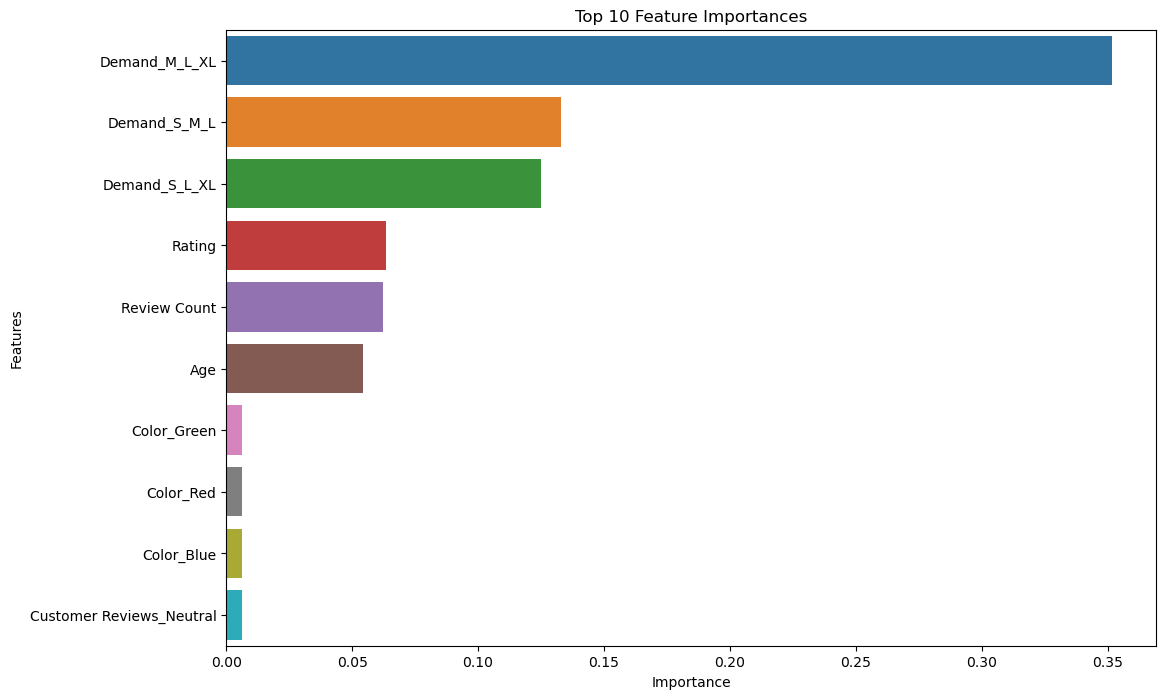

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
importances_df = pd.DataFrame({'features': feature_names, 'importance': feature_importances})

# Sort by importance
importances_df = importances_df.sort_values(by='importance', ascending=False).head(10)  

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=importances_df, x='importance', y='features')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()